<a href="https://colab.research.google.com/github/Zeeshan-CR7/Ticket-Classification-using-Topic-Modelling-NLP-/blob/main/Ticket_Classification_Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [56]:
import json 
import numpy as np
import pandas as pd

import pickle
import re, nltk, spacy, string

import en_core_web_sm
nlp = en_core_web_sm.load()

nlp = spacy.load("en_core_web_sm")
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import NMF

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, classification_report

from pprint import pprint
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Opening JSON file 
f = open('/content/drive/MyDrive/Data_sets/complaints-2021-05-14_08_16.json')
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df = pd.json_normalize(data)
df

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78308,complaint-public-v2,complaint,3105617,0.0,None,08857,3105617,Closing an account,2018-12-20T12:00:00-05:00,NJ,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2018-12-21T12:00:00-05:00,None,Checking account,Yes,,Funds not received from closed account,Consent not provided
78309,complaint-public-v2,complaint,3091984,0.0,None,934XX,3091984,"Other features, terms, or problems",2018-12-05T12:00:00-05:00,CA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2018-12-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",Other problem,Consent provided
78310,complaint-public-v2,complaint,3133355,0.0,None,923XX,3133355,Problem with a lender or other company chargin...,2019-01-25T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-01-25T12:00:00-05:00,None,Checking account,Yes,I am not familiar with XXXX pay and did not un...,Transaction was not authorized,Consent provided
78311,complaint-public-v2,complaint,3110963,0.0,None,None,3110963,"Other features, terms, or problems",2018-12-27T12:00:00-05:00,PA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2018-12-27T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I have had flawless credit for 30 yrs. I've ha...,Problem with balance transfer,Consent provided


## Data preparation

In [4]:
# Inspect the dataframe to understand the given data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [5]:
#print the column names
list(df.columns)

['_index',
 '_type',
 '_id',
 '_score',
 '_source.tags',
 '_source.zip_code',
 '_source.complaint_id',
 '_source.issue',
 '_source.date_received',
 '_source.state',
 '_source.consumer_disputed',
 '_source.product',
 '_source.company_response',
 '_source.company',
 '_source.submitted_via',
 '_source.date_sent_to_company',
 '_source.company_public_response',
 '_source.sub_product',
 '_source.timely',
 '_source.complaint_what_happened',
 '_source.sub_issue',
 '_source.consumer_consent_provided']

In [6]:
#Assign new column names
df.columns = [re.sub('^_','', col) for col in df.columns]
df.columns = [re.sub(r'^\bsource\b\.','',col) for col in df.columns]
list(df.columns)

['index',
 'type',
 'id',
 'score',
 'tags',
 'zip_code',
 'complaint_id',
 'issue',
 'date_received',
 'state',
 'consumer_disputed',
 'product',
 'company_response',
 'company',
 'submitted_via',
 'date_sent_to_company',
 'company_public_response',
 'sub_product',
 'timely',
 'complaint_what_happened',
 'sub_issue',
 'consumer_consent_provided']

In [7]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened'].replace("", np.nan, inplace= True)
df['complaint_what_happened']

0                                                      NaN
1        Good morning my name is XXXX XXXX and I apprec...
2        I upgraded my XXXX XXXX card in XX/XX/2018 and...
3                                                      NaN
4                                                      NaN
                               ...                        
78308                                                  NaN
78309    On Wednesday, XX/XX/XXXX I called Chas, my XXX...
78310    I am not familiar with XXXX pay and did not un...
78311    I have had flawless credit for 30 yrs. I've ha...
78312    Roughly 10+ years ago I closed out my accounts...
Name: complaint_what_happened, Length: 78313, dtype: object

In [8]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaint_what_happened'], inplace = True)
df.shape

(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [9]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean(text):
    text = text.lower() #Make the text lowercase
    text = re.sub(r'\[.*?\]', '', text) #Remove text in square brackets
    text = re.sub(r'[^\w\s]', '', text) #Remove punctuation
    text = re.sub(r'\w*\d+\w*', '', text) #Remove words containing numbers
    return text

df_clean = pd.DataFrame(df.complaint_what_happened.apply(lambda x: clean(x)))

In [10]:
#Write your function to Lemmatize the texts
def lemmatizer(text):
    sent = [] # Initialize empty list to store lemmas forms
    doc = nlp(text) # Extract lemmas of given text and add to the list 'sent'
    for word in doc:
        sent.append(word.lemma_)
    return " ".join(sent) # return string converted form of the list of lemmas

In [11]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean["lemmatized_complaints"] = df_clean.apply(lambda x: lemmatizer(x['complaint_what_happened']), axis=1)

In [12]:
df_clean

,complaint_what_happened,lemmatized_complaints
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...
...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yr I ve have...


In [13]:
# lemmatized text with all the words removed which have tags other than NN[tag == "NN"]
text = df_clean.loc[1, 'lemmatized_complaints']
text

'good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in   I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account   xxxx xxxx xxxx xxxx thank in advance for your help'

In [18]:
# Trying to extract word which has tags == 'NN' using spacy & textblob to see the difference 
spac =[]
doc = nlp(text)
for token in doc:
  if token.tag_ == 'NN':
    spac.append(token.text)
print('Spacy-->', ' '.join(spac))

blb =[]
blob = TextBlob(text)
for i in blob.tags:
  if i[1] == 'NN':
    blb.append(i[0])
print('\nTextblob-->', ' '.join(blb))
print('\nOrginal-->', text)

Spacy--> morning name stop debt verification statement bank debt mail month debt right information consumer chase account advance help

Textblob--> morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help

Orginal--> good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service 
 in   I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt 
 I have a right to know this information as a consumer 

 chase account   xxxx xxxx xxxx xxxx thank in advance for your help


In [19]:
#Write your function to extract the POS tags
# Since the lot of information such as [bank, cardmember, service, ask] is lost in spacy library lets proceed with textblob for this usecase
def pos_tag(text):
    try:
        return TextBlob(text).tags
    except:
        return None

def get_singular_nouns(text):
    blob = TextBlob(text)
    return ' '.join([ word for (word,tag) in blob.tags if tag == "NN"])

df_clean["complaint_POS_removed"] =  df_clean.apply(lambda x: get_singular_nouns(x['lemmatized_complaints']), axis=1)

In [20]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...
...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,visa credit card provider claim purchase prote...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yr I ve have...,credit yr credit card chase freedom xxxx probl...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




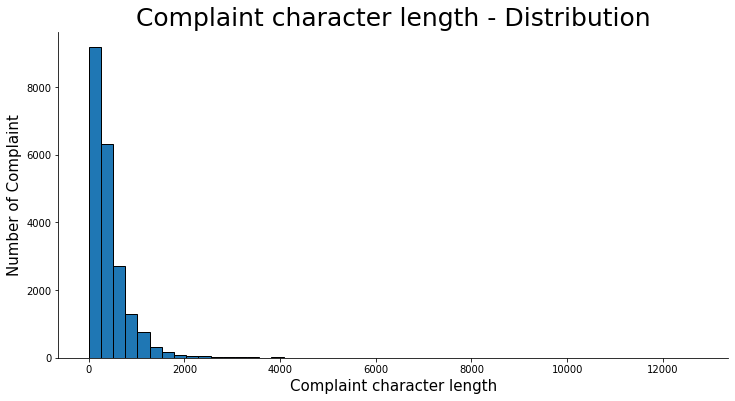

In [21]:
# Write your code here to visualise the data according to the 'Complaint' character length
doc_lengths = [len(data) for data in df_clean['complaint_POS_removed']]
plt.figure(figsize=(12,6))
plt.hist(doc_lengths, edgecolor='black', bins = 50)
plt.title('Complaint character length - Distribution', fontsize=25)
plt.ylabel('Number of Complaint', fontsize=15)
plt.xlabel('Complaint character length', fontsize=15)
sns.despine()
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

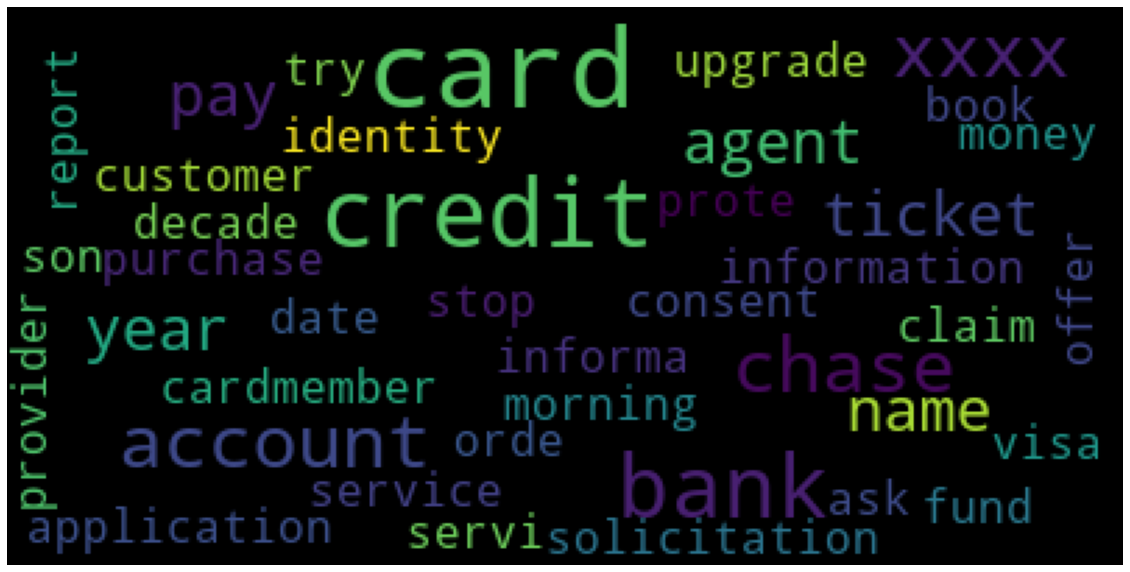

In [22]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, max_words=40, max_font_size=40, random_state=42).generate(str(df_clean['complaint_POS_removed']))

fig = plt.figure(figsize=(20,15))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [23]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [24]:
# Custom fuction to get n grams. 
def get_top_n_words(corpus, freqtype, n=None):
  if freqtype == 'unigram':
    vector = CountVectorizer(stop_words='english').fit(corpus)
  elif freqtype == 'bigram':
    vector = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
  else:
    vector = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
  bag_of_words = vector.transform(corpus)
  sum_words = bag_of_words.sum(axis=0)
  words_freq = [(word, sum_words[0, idx]) for word, idx in vector.vocabulary_.items()]
  words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
  return words_freq[:n]

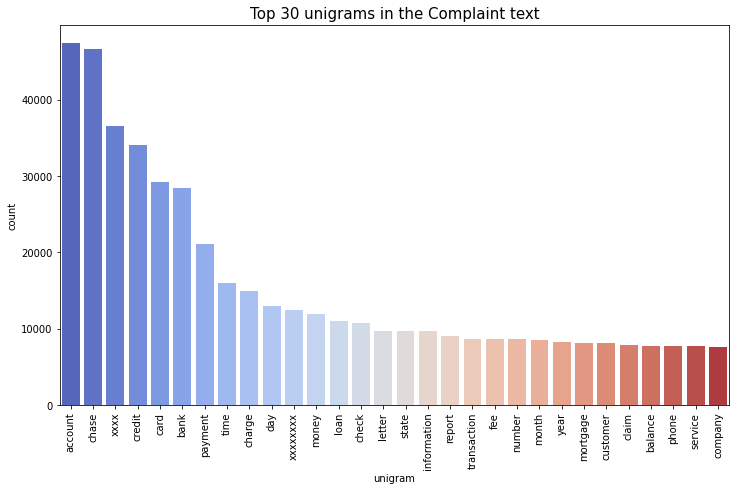

In [25]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean)
uni_words = get_top_n_words(df_clean['Complaint_clean'].values.astype('U'), 'unigram', 30)
uni_df = pd.DataFrame(uni_words, columns = ['unigram' , 'count'])

# Ploting the top 30 unigrams
plt.figure(figsize=(12, 7))
sns.barplot(x='unigram', y='count', data = uni_df, palette = "coolwarm")
plt.xticks(rotation=90)
plt.title("Top 30 unigrams in the Complaint text", fontsize=15)
plt.show()

In [26]:
#Print the top 10 words in the unigram frequency
uni_df.head(10)

,unigram,count
0,account,47492
1,chase,46692
2,xxxx,36530
3,credit,34132
4,card,29279
5,bank,28407
6,payment,21166
7,time,16033
8,charge,14992
9,day,12966


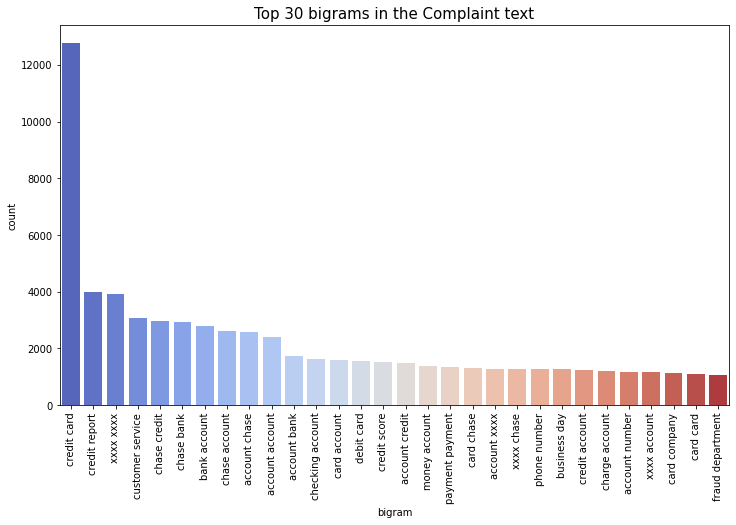

In [27]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
bi_words = get_top_n_words(df_clean['Complaint_clean'].values.astype('U'), 'bigram', 30)
bi_df = pd.DataFrame(bi_words, columns = ['bigram' , 'count'])

# Ploting the top 30 bigrams
plt.figure(figsize=(12, 7))
sns.barplot(x='bigram', y='count', data = bi_df, palette = "coolwarm")
plt.xticks(rotation=90)
plt.title("Top 30 bigrams in the Complaint text", fontsize=15)
plt.show()

In [28]:
#Print the top 10 words in the bigram frequency
bi_df.head(10)

,bigram,count
0,credit card,12779
1,credit report,4003
2,xxxx xxxx,3931
3,customer service,3079
4,chase credit,2967
5,chase bank,2942
6,bank account,2778
7,chase account,2619
8,account chase,2595
9,account account,2414


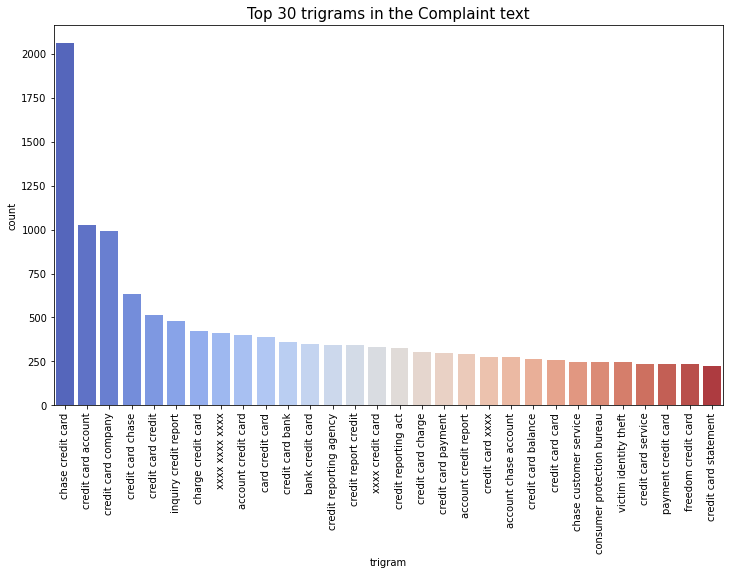

In [29]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
tri_words = get_top_n_words(df_clean['Complaint_clean'].values.astype('U'), 'trigram', 30)
tri_df = pd.DataFrame(tri_words, columns = ['trigram' , 'count'])

# Ploting the top 30 trigrams
plt.figure(figsize=(12, 7))
sns.barplot(x='trigram', y='count', data = tri_df, palette = "coolwarm")
plt.xticks(rotation=90)
plt.title("Top 30 trigrams in the Complaint text", fontsize=15)
plt.show()

In [30]:
#Print the top 10 words in the trigram frequency
tri_df.head(10)

,trigram,count
0,chase credit card,2063
1,credit card account,1026
2,credit card company,990
3,credit card chase,634
4,credit card credit,514
5,inquiry credit report,480
6,charge credit card,422
7,xxxx xxxx xxxx,410
8,account credit card,401
9,card credit card,388


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [31]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [32]:
#All masked texts has been removed
df_clean

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yr I ve have...,credit yr credit card chase freedom xxxx probl...,credit yr credit card chase freedom problem b...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [33]:
#Write your code here to initialise the TfidfVectorizer 
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [34]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
document_term = tfidf.fit_transform(df_clean['Complaint_clean'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [35]:
from sklearn.decomposition import NMF

## Automatic Topic Modeling
We already know there are 5 topics from the objective of the case study. Lets us simply try finding a optimal number of topics from the corpus of text using coherance model if no information was given.

In [47]:
# Importing from gensim
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel
from operator import itemgetter

In [52]:
# Getting the clean complaints in form of coherance model inputs
text = df_clean['Complaint_clean']
dataset = [d.split() for d in text]
dictionary = Dictionary(dataset)
dictionary.filter_extremes(no_below=5, no_above=0.80, keep_n=5000)

In [53]:
corpus = [dictionary.doc2bow(text) for text in dataset] # list of (token_id, token_count)
topic_nums = list(np.arange(5, 10, 1)) #list of the topic numbers we want to try

In [54]:
coherence_scores = [] #For storing coherance score of each given number of topics
for num in topic_nums:
    nmf = Nmf(corpus=corpus,
              num_topics=num,
              id2word=dictionary,
              chunksize=2000,
              passes=5,
              kappa=.1,
              minimum_probability=0.01,
              w_max_iter=300,
              w_stop_condition=0.0001,
              h_max_iter=100,
              h_stop_condition=0.001,
              eval_every=10,
              normalize=True,
              random_state=42)
    
    cm = CoherenceModel(model=nmf, texts=text, dictionary=dictionary, coherence='c_v')
    coherence_scores.append(round(cm.get_coherence(), 5))

In [55]:
scores = list(zip(topic_nums, coherence_scores))
print(sorted(scores, key=itemgetter(1), reverse=True)[0][0])

5


## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [36]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components = num_topics, random_state = 40)

In [37]:
nmf_model.fit(document_term)
len(tfidf.get_feature_names())

7256

In [38]:
#Print the Top15 words for each of the topics
for idx, topic in enumerate(nmf_model.components_):
  print(f'The top 15 words for topic--> {idx}')
  print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
  print('\n')

The top 15 words for topic--> 0
['transfer', 'claim', 'checking', 'transaction', 'business', 'number', 'day', 'branch', 'deposit', 'chase', 'fund', 'money', 'check', 'bank', 'account']


The top 15 words for topic--> 1
['balance', 'year', 'letter', 'application', 'debt', 'information', 'limit', 'company', 'score', 'account', 'chase', 'inquiry', 'report', 'card', 'credit']


The top 15 words for topic--> 2
['mortgage', 'year', 'chase', 'account', 'credit', 'pay', 'date', 'auto', 'time', 'day', 'statement', 'fee', 'month', 'balance', 'payment']


The top 15 words for topic--> 3
['company', 'refund', 'statement', 'time', 'service', 'claim', 'purchase', 'fraud', 'merchant', 'chase', 'dispute', 'transaction', 'fee', 'card', 'charge']


The top 15 words for topic--> 4
['sale', 'foreclosure', 'house', 'bank', 'document', 'time', 'rate', 'letter', 'year', 'property', 'chase', 'modification', 'home', 'mortgage', 'loan']




In [39]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
best_topic = nmf_model.transform(document_term)
best_topic[0].round(2)
best_topic[0].argmax()
best_topic.argmax(axis=1)

array([0, 1, 1, ..., 3, 2, 2])

In [40]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = best_topic.argmax(axis=1)

In [41]:
df_clean.head()

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0


In [42]:
#Print the first 5 Complaint for each of the Topics
df_clean_groupby = df_clean.groupby('Topic').head(5)
df_clean_groupby.sort_values('Topic')

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,jp chase account debit card tuesday thursday b...,jp chase account debit card tuesday thursday b...,0
24,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xxxx,mishandle account auto xxxx,mishandle account auto,0
27,i opened an account with chase bank on xxxx an...,I open an account with chase bank on xxxx and ...,account bank code bonus term everything accoun...,account bank code bonus term everything accoun...,0
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
15,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,1
23,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,chase credit card datum credit report company ...,chase credit card datum credit report company ...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [43]:
#Create the dictionary of Topic names and Topics
Topic_names = {0:"Bank Account services",
               1:"Credit card or prepaid card", 
               2:"Others",
               3:"Theft/Dispute Reporting",
               4:"Mortgage/Loan"}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [44]:
df_clean

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,Bank Account services
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,Credit card or prepaid card
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,Credit card or prepaid card
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,Credit card or prepaid card
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,Bank Account services
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...,Credit card or prepaid card
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...,Theft/Dispute Reporting
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...,Theft/Dispute Reporting
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yr I ve have...,credit yr credit card chase freedom xxxx probl...,credit yr credit card chase freedom problem b...,Others


In [46]:
# df_clean.to_csv('/content/drive/MyDrive/Data_sets/df_clean.csv', index = False)

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [49]:
#Create the dictionary again of Topic names and Topics
Topic_names = {"Bank Account services":0, 
               "Credit card or prepaid card":1,
               "Others":2,
               "Theft/Dispute Reporting":3,
               "Mortgage/Loan":4}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [50]:
df_clean

,complaint_what_happened,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...,3
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...,3
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yr I ve have...,credit yr credit card chase freedom xxxx probl...,credit yr credit card chase freedom problem b...,2


In [51]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[['complaint_what_happened', 'Topic']]

In [52]:
training_data

,complaint_what_happened,Topic
1,good morning my name is xxxx xxxx and i apprec...,0
2,i upgraded my xxxx xxxx card in and was told ...,1
10,chase card was reported on however fraudulent...,1
11,on while trying to book a xxxx xxxx ticket ...,1
14,my grand son give me check for i deposit it i...,0
...,...,...
78303,after being a chase card customer for well ove...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,3
78310,i am not familiar with xxxx pay and did not un...,3
78311,i have had flawless credit for yrs ive had ch...,2


In [53]:
# View value counts of the five topics
training_data['Topic'].value_counts()

0    5248
1    5011
3    4737
4    3814
2    2262
Name: Topic, dtype: int64

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [54]:
#Write your code to get the Vector count
count_vect = CountVectorizer()
vectorizer = count_vect.fit_transform(training_data['complaint_what_happened'])

#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(vectorizer)

In [58]:
# Perform Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data['Topic'], test_size=0.2, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (16857, 33665)
Shape of y_train: (16857,)
Shape of X_test: (4215, 33665)
Shape of y_test: (4215,)


In [62]:
# Creating a function to evaluate different models
def classify(model):
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  print('F1 score-->', f1_score(y_test, y_pred, average="weighted"))
  print(f"\nEvaluation Report for {model}\n")
  print(classification_report(y_test, y_pred, target_names=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting", "Mortgage/Loan"]))
  return

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [63]:
# Logistic Regression
lr = LogisticRegression(C=1, penalty='l1', solver='saga')
classify(lr)

F1 score--> 0.9422295844096826

Evaluation Report for LogisticRegression(C=1, penalty='l1', solver='saga')

                             precision    recall  f1-score   support

      Bank Account services       0.94      0.96      0.95      1061
Credit card or prepaid card       0.95      0.95      0.95      1047
                     Others       0.93      0.96      0.94       440
    Theft/Dispute Reporting       0.94      0.90      0.92       951
              Mortgage/Loan       0.95      0.94      0.95       716

                   accuracy                           0.94      4215
                  macro avg       0.94      0.94      0.94      4215
               weighted avg       0.94      0.94      0.94      4215



In [64]:
# Decision Tree
dt = DecisionTreeClassifier(criterion='gini', max_depth=30, min_samples_leaf=15, max_features=None)
classify(dt)

F1 score--> 0.8040729461466104

Evaluation Report for DecisionTreeClassifier(max_depth=30, min_samples_leaf=15)

                             precision    recall  f1-score   support

      Bank Account services       0.82      0.82      0.82      1061
Credit card or prepaid card       0.82      0.84      0.83      1047
                     Others       0.78      0.78      0.78       440
    Theft/Dispute Reporting       0.77      0.73      0.75       951
              Mortgage/Loan       0.82      0.84      0.83       716

                   accuracy                           0.80      4215
                  macro avg       0.80      0.80      0.80      4215
               weighted avg       0.80      0.80      0.80      4215



In [65]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, min_samples_split=5, min_samples_leaf=5, max_features=None, max_depth=30, criterion='gini')
classify(rf)

F1 score--> 0.8501444333666877

Evaluation Report for RandomForestClassifier(max_depth=30, max_features=None, min_samples_leaf=5,
                       min_samples_split=5)

                             precision    recall  f1-score   support

      Bank Account services       0.86      0.88      0.87      1061
Credit card or prepaid card       0.86      0.88      0.87      1047
                     Others       0.83      0.84      0.84       440
    Theft/Dispute Reporting       0.83      0.78      0.81       951
              Mortgage/Loan       0.85      0.87      0.86       716

                   accuracy                           0.85      4215
                  macro avg       0.85      0.85      0.85      4215
               weighted avg       0.85      0.85      0.85      4215



In [66]:
# Naive Bayes
nb = MultinomialNB()
classify(nb)

F1 score--> 0.6815496464077405

Evaluation Report for MultinomialNB()

                             precision    recall  f1-score   support

      Bank Account services       0.63      0.91      0.75      1061
Credit card or prepaid card       0.72      0.76      0.74      1047
                     Others       1.00      0.01      0.02       440
    Theft/Dispute Reporting       0.76      0.76      0.76       951
              Mortgage/Loan       0.85      0.76      0.80       716

                   accuracy                           0.72      4215
                  macro avg       0.79      0.64      0.61      4215
               weighted avg       0.76      0.72      0.68      4215



#### After comparing all 4 models we could conclude that Logistic regression performed well with an F1 score or 94%. Lets now try to infer new quries to respective topic


In [82]:
new_data = ['I want to open a savings account at your main branch']
names = ["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting", "Mortgage/Loan"]
new_count = count_vect.transform(new_data)
new_tfidf = tfidf_transformer.transform(new_count)
val = lr.predict(new_tfidf)[0]
names[val]

'Bank Account services'

In [84]:
new_data = ['Need to block my debit card as it is stolen']
names = ["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting", "Mortgage/Loan"]
new_count = count_vect.transform(new_data)
new_tfidf = tfidf_transformer.transform(new_count)
val = lr.predict(new_tfidf)[0]
names[val]

'Theft/Dispute Reporting'

In [86]:
new_data = ['What would be the intrest rate of home loan for loan amount of 10 lakhs and duration of 5 years']
names = ["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting", "Mortgage/Loan"]
new_count = count_vect.transform(new_data)
new_tfidf = tfidf_transformer.transform(new_count)
val = lr.predict(new_tfidf)[0]
names[val]

'Mortgage/Loan'

### <u>Insights</u>:

- Model performs very well in classifying new text.
- Logistic regression model picked for classification of tickets.
- F1 score accross all the tickets is around 94% which is extreamly good.